# What jobs?

In [1]:
from Scratch import metadata_loader


DEVICE = "ibm_torino"
LOGICAL = str(0)
XBASIS = False
ROUNDS = 50

state = "X" if XBASIS else "Z"
state += LOGICAL
print(f"state = {state}")

# Load the metadata
md = metadata_loader(True, True)
md = md[md["job_status"] == "JobStatus.DONE"]
md = md[md["code"] == "RepetitionCodeCircuit"]
md = md[md["descr"] == 'subset RepCodes']
md = md.dropna(subset=["rounds"])
md = md[md["meas_level"] == 1]
md['rounds'] = md['rounds'].astype(int)
md['distance'] = md['distance'].astype(int)

md = md[md["backend_name"] == DEVICE]
md = md[md["logical"] == LOGICAL]
md = md[md["xbasis"] == XBASIS]
md = md[md["rounds"] == ROUNDS]

md = md[:]
print("shape:", md.shape)
md[:2]

state = Z0
shape: (40, 18)


,creation_date,notebook_name,backend_name,job_id,tags,meas_level,shots,num_qubits,job_status,execution_date,code,distance,rounds,logical,descr,resets,xbasis,path_info
5483,2024-03-24 15:59:50.864000+01:00,Torino_RepCodes_jobs,ibm_torino,cr03zsqdvs8g008j7ra0,"[Subset 56, 50 rounds, 0 log, xbasis=False]",1.0,1398.0,NaN,JobStatus.DONE,2024-03-24 16:51:12.990431+01:00,RepetitionCodeCircuit,56,50,0,subset RepCodes,NaN,False,"{'mean_gate_error': 0.006452510204489, 'min_ga..."
5482,2024-03-24 15:59:44.592000+01:00,Torino_RepCodes_jobs,ibm_torino,cr03zr7k5z700081s2tg,"[Subset 56, 50 rounds, 0 log, xbasis=False]",1.0,1398.0,NaN,JobStatus.DONE,2024-03-24 16:50:44.865382+01:00,RepetitionCodeCircuit,56,50,0,subset RepCodes,NaN,False,"{'mean_gate_error': 0.006452510204489, 'min_ga..."


# Load the data

In [2]:
import json

SOFT_MUL = 0.5

# file_name = f'../results/{state}_{ROUNDS}.json'
file_name = f'../results/InfoPerfo_{DEVICE}_{state}_{ROUNDS}_soft_{SOFT_MUL}.json'


with open(file_name, 'r') as f:
    decoding_data = json.load(f)

print(len(decoding_data.keys()))

3


# Get the cummulative error dict

In [77]:
import numpy as np

d_new_dict = {}
for key, result_list in decoding_data.items():
    for result in result_list:
        if result.get("shots", 0) != 0:
            shots = result["shots"]
        elif result.get("nb_of_bits", 0) != 0:
            nb_of_bits = result["nb_of_bits"]
        else:
            d_new = int(result["d_new"])
            error_list = result["error_list"]
            nb_subsets = len(error_list)
            mean_err_per_bit = np.zeros(len(error_list[0]))
            for error_per_bit in error_list:
                mean_err_per_bit += np.array(error_per_bit)
            mean_err_per_bit /= nb_subsets
        if d_new in d_new_dict:
            d_new_dict[d_new]["mean_err_per_bit"] += mean_err_per_bit
            d_new_dict[d_new]["shots"] += shots * nb_subsets
        else:
            d_new_dict[d_new] = {
                "mean_err_per_bit": mean_err_per_bit,
                "shots": shots * nb_subsets,
                "nb_of_bits": nb_of_bits,
            }

# error_dict = {}
# for d_new, data in d_new_dict.items():
#     error_dict[d_new] = data["mean_err_per_bit"] / data["shots"]
# error_dict
            

print(d_new_dict.keys())

dict_keys([7, 55, 51, 47, 43, 39, 35, 31, 27, 23, 19, 15, 11, 3])


# Plot

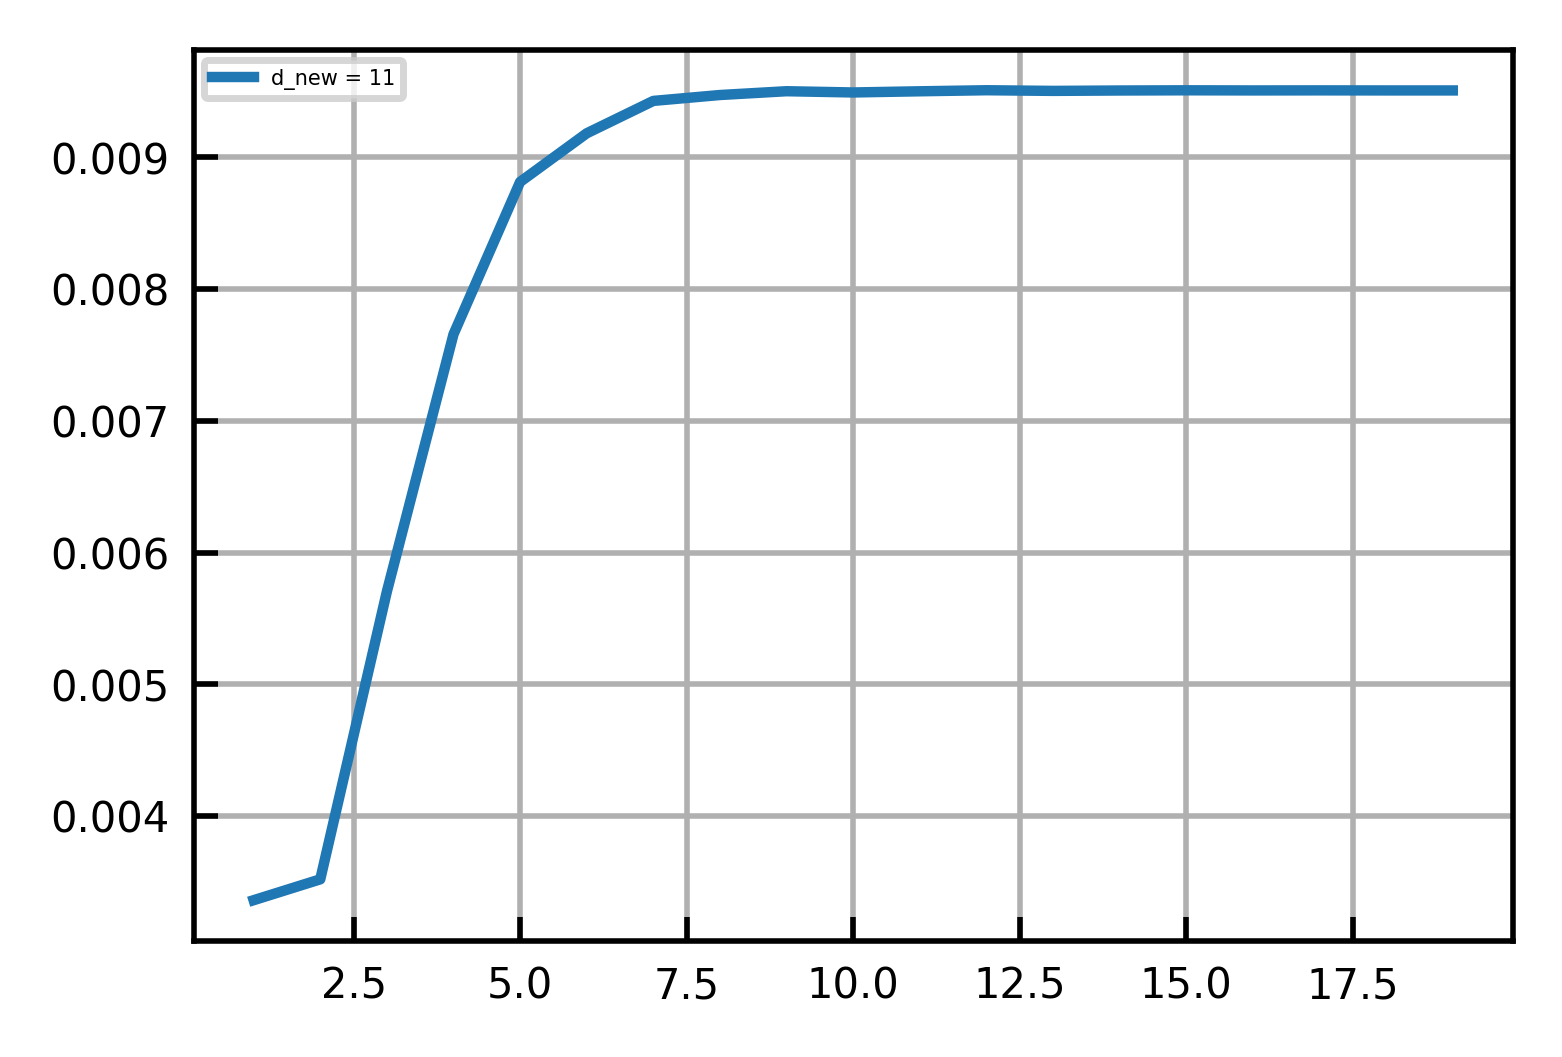

In [79]:
import matplotlib.pyplot as plt

for d_new, data in d_new_dict.items():
    if d_new != 11:
        continue

    errs = data["mean_err_per_bit"]/data["shots"]
    bits = data["nb_of_bits"]

    plt.plot(bits, errs, label=f"d_new = {d_new}")
    plt.legend(fontsize=3)
    plt.grid()


ValueError: 'x' is not 1-dimensional

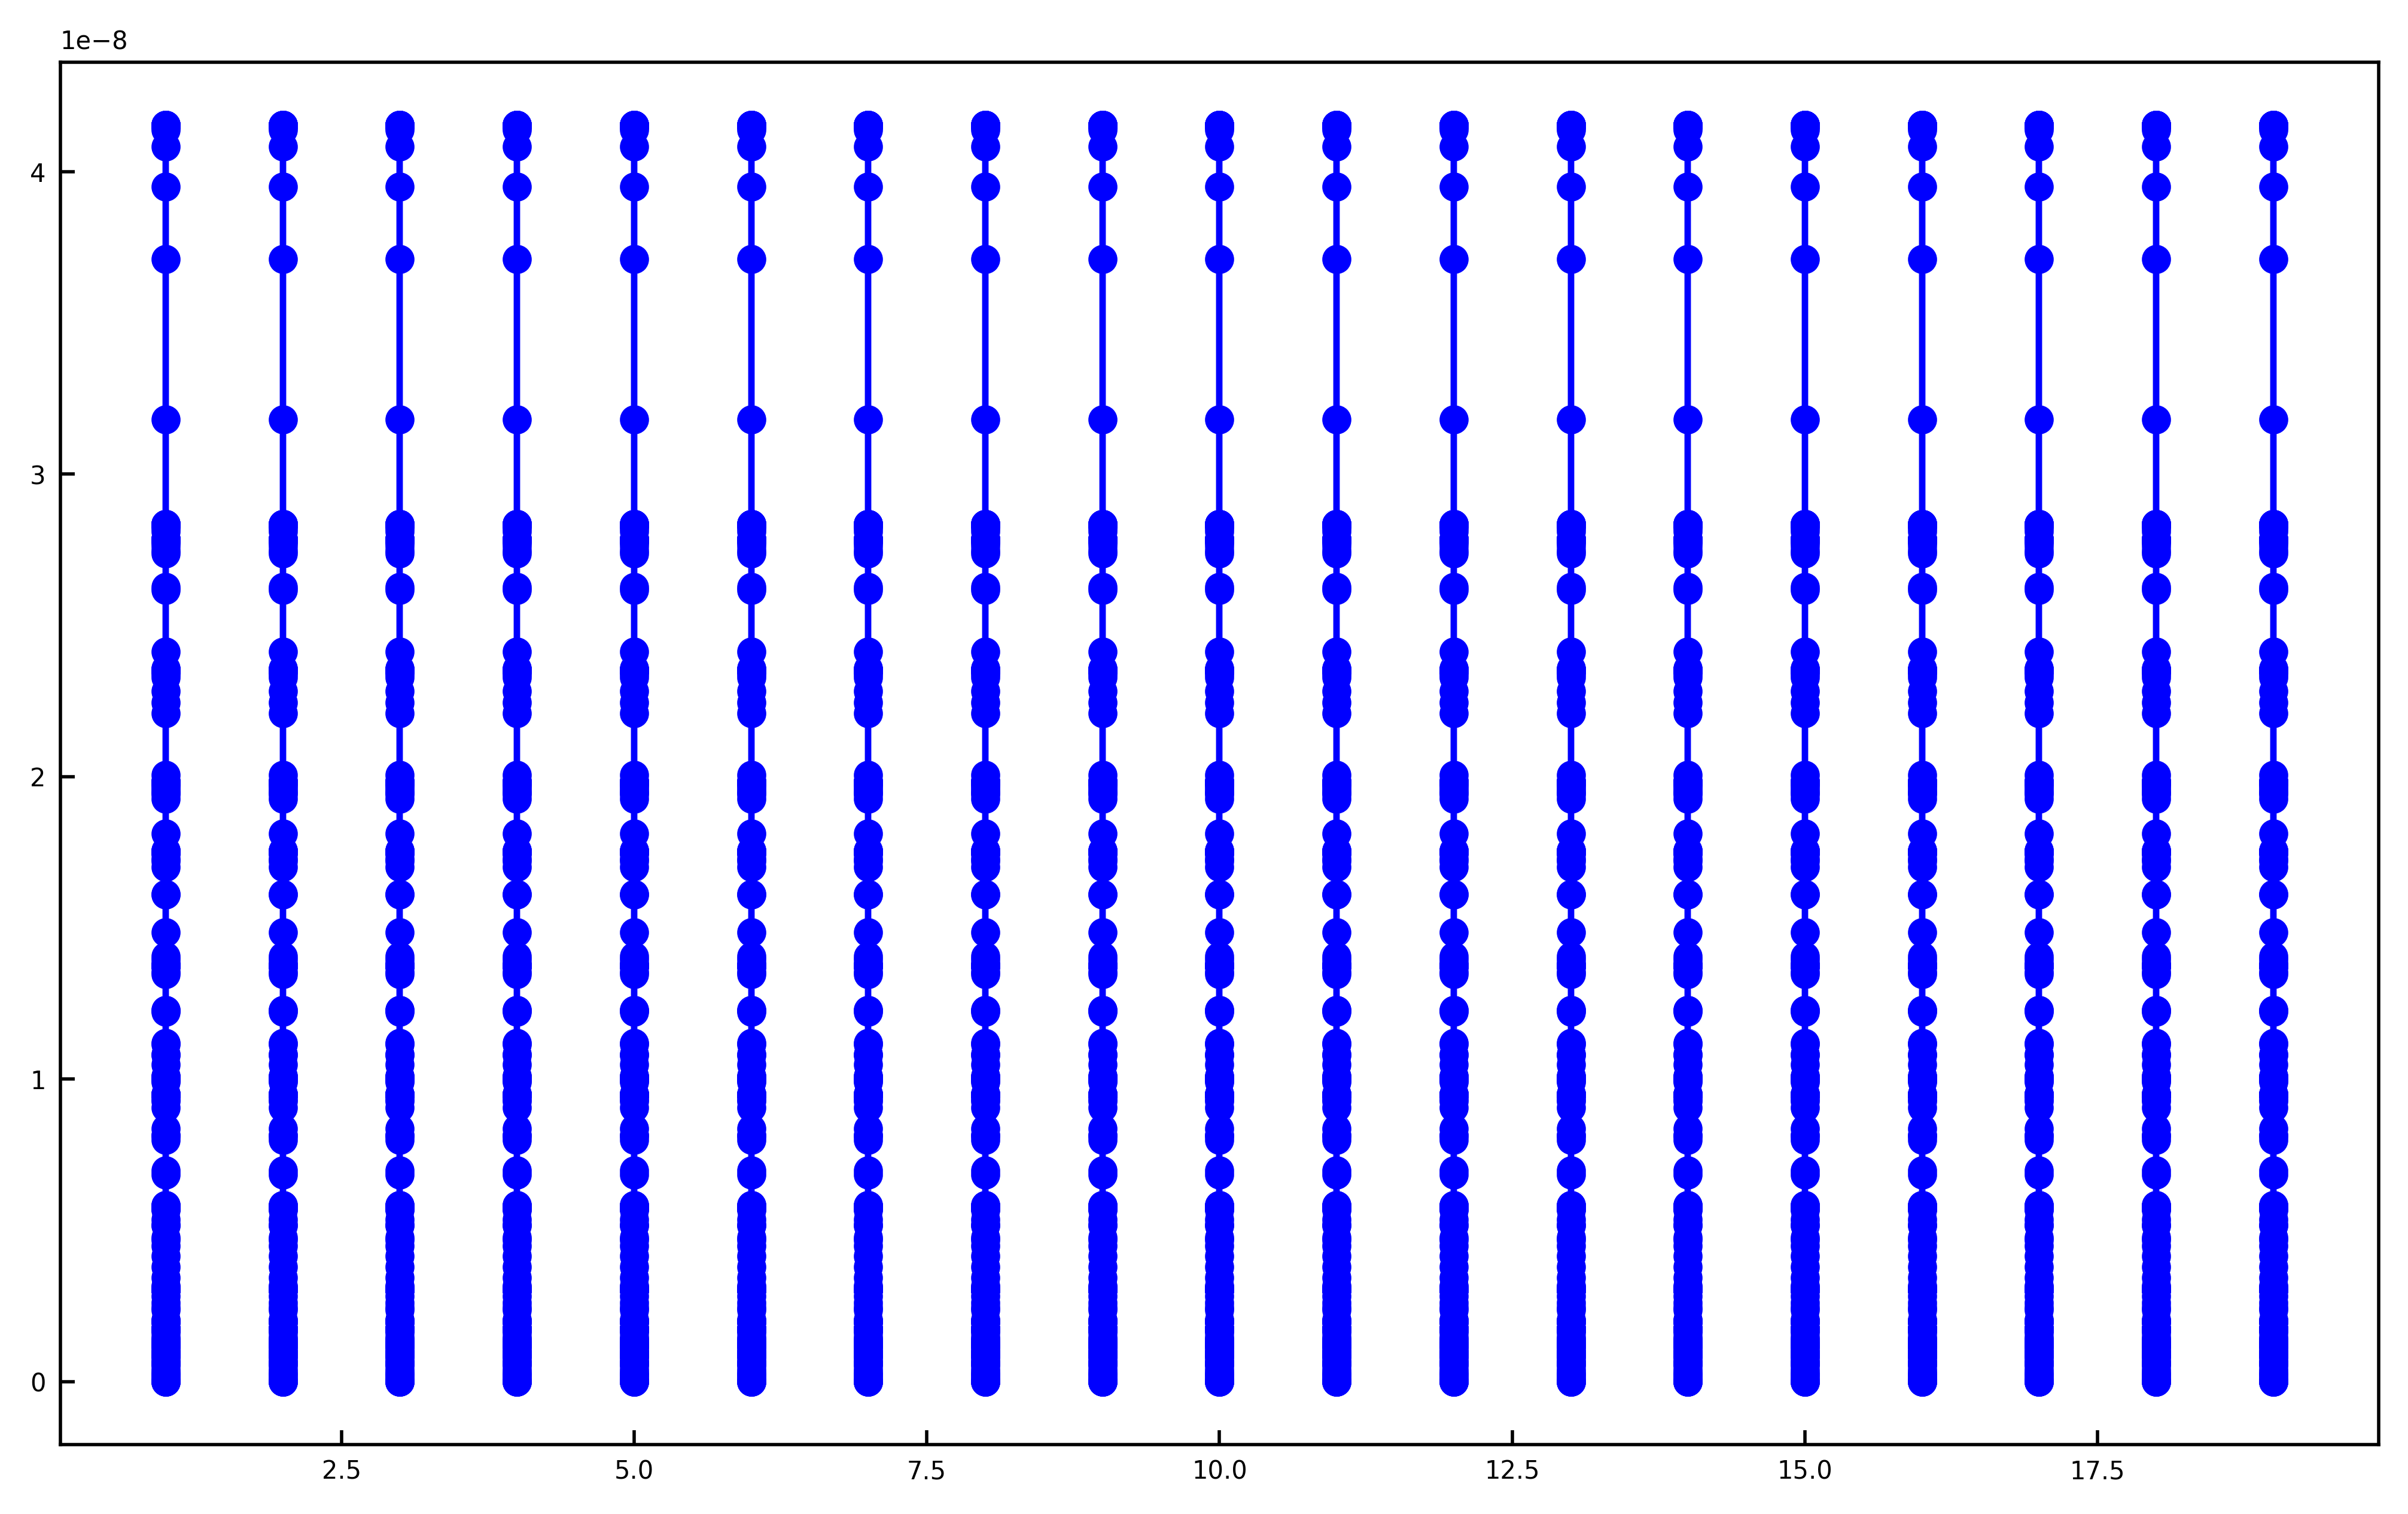

In [65]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

FIGURE_WIDTH_1COL = 3.404  # For PRX style, change for according to journal
FIGURE_WIDTH_2COL = 7.057  # For PRX style, change for according to journal
FIGURE_HEIGHT_1COL_GR = FIGURE_WIDTH_1COL*2/(1 + np.sqrt(5))*1.1
FIGURE_HEIGHT_2COL_GR = FIGURE_WIDTH_2COL*2/(1 + np.sqrt(5))*1.1

font_size = 6 # For PRX style, change for according to journal

plt.rcParams.update({
    'font.size'           : font_size,  
    'figure.titlesize'    : 'medium',
    'figure.dpi'          : 500,
    'figure.figsize'      : (FIGURE_WIDTH_1COL, FIGURE_HEIGHT_1COL_GR),
    'axes.titlesize'      : 'medium',
    'axes.axisbelow'      : True,
    'xtick.direction'     : 'in',
    'xtick.labelsize'     : 'small',
    'ytick.direction'     : 'in',
    'ytick.labelsize'     : 'small',
    'image.interpolation' : 'none',
    'legend.fontsize'     : font_size,
    'axes.labelsize'      : font_size,
    'axes.titlesize'      : font_size,
    'xtick.labelsize'     : font_size,
    'ytick.labelsize'     : font_size,
})

# Wilson score interval function
def wilson_score_interval(p, n, z=1.96):  # Using z=1.96 for a 95% confidence interval
    denominator = 1 + z**2 / n
    term = z * np.sqrt(p * (1 - p) / n + z**2 / (4 * n**2))
    lower = (p + z**2 / (2 * n) - term) / denominator
    upper = (p + z**2 / (2 * n) + term) / denominator
    return max(lower, 0), min(upper, 1)

# Assuming the dictionary is named d_new_dict as provided
nb_of_bits_list = []
err_rates = []
lowers = []
uppers = []

# Iterate over the d_new_dict to calculate error rates and confidence intervals
for d_new, data in d_new_dict.items():
    mean_err_per_bit = data["mean_err_per_bit"] / data["shots"]
    nb_of_bits = data["nb_of_bits"]
    
    for i, err in enumerate(mean_err_per_bit):
        p = err / data["shots"]
        lower, upper = wilson_score_interval(p, data["shots"])
        
        nb_of_bits_list.append(nb_of_bits)
        err_rates.append(p)
        lowers.append(lower)
        uppers.append(upper)

# Plotting
plt.figure(figsize=(10, 6))

# Since the error rates, lowers, and uppers are calculated per bit, we plot them against nb_of_bits
plt.plot(nb_of_bits_list, err_rates, label="Error Rate", marker='o', color='blue')
plt.fill_between(nb_of_bits_list, lowers, uppers, color='blue', alpha=0.1)

plt.yscale("log")
plt.ylabel('Error rate (log scale)')
plt.xlabel('Number of Bits')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.title('Error Rates by Number of Bits')

plt.show()

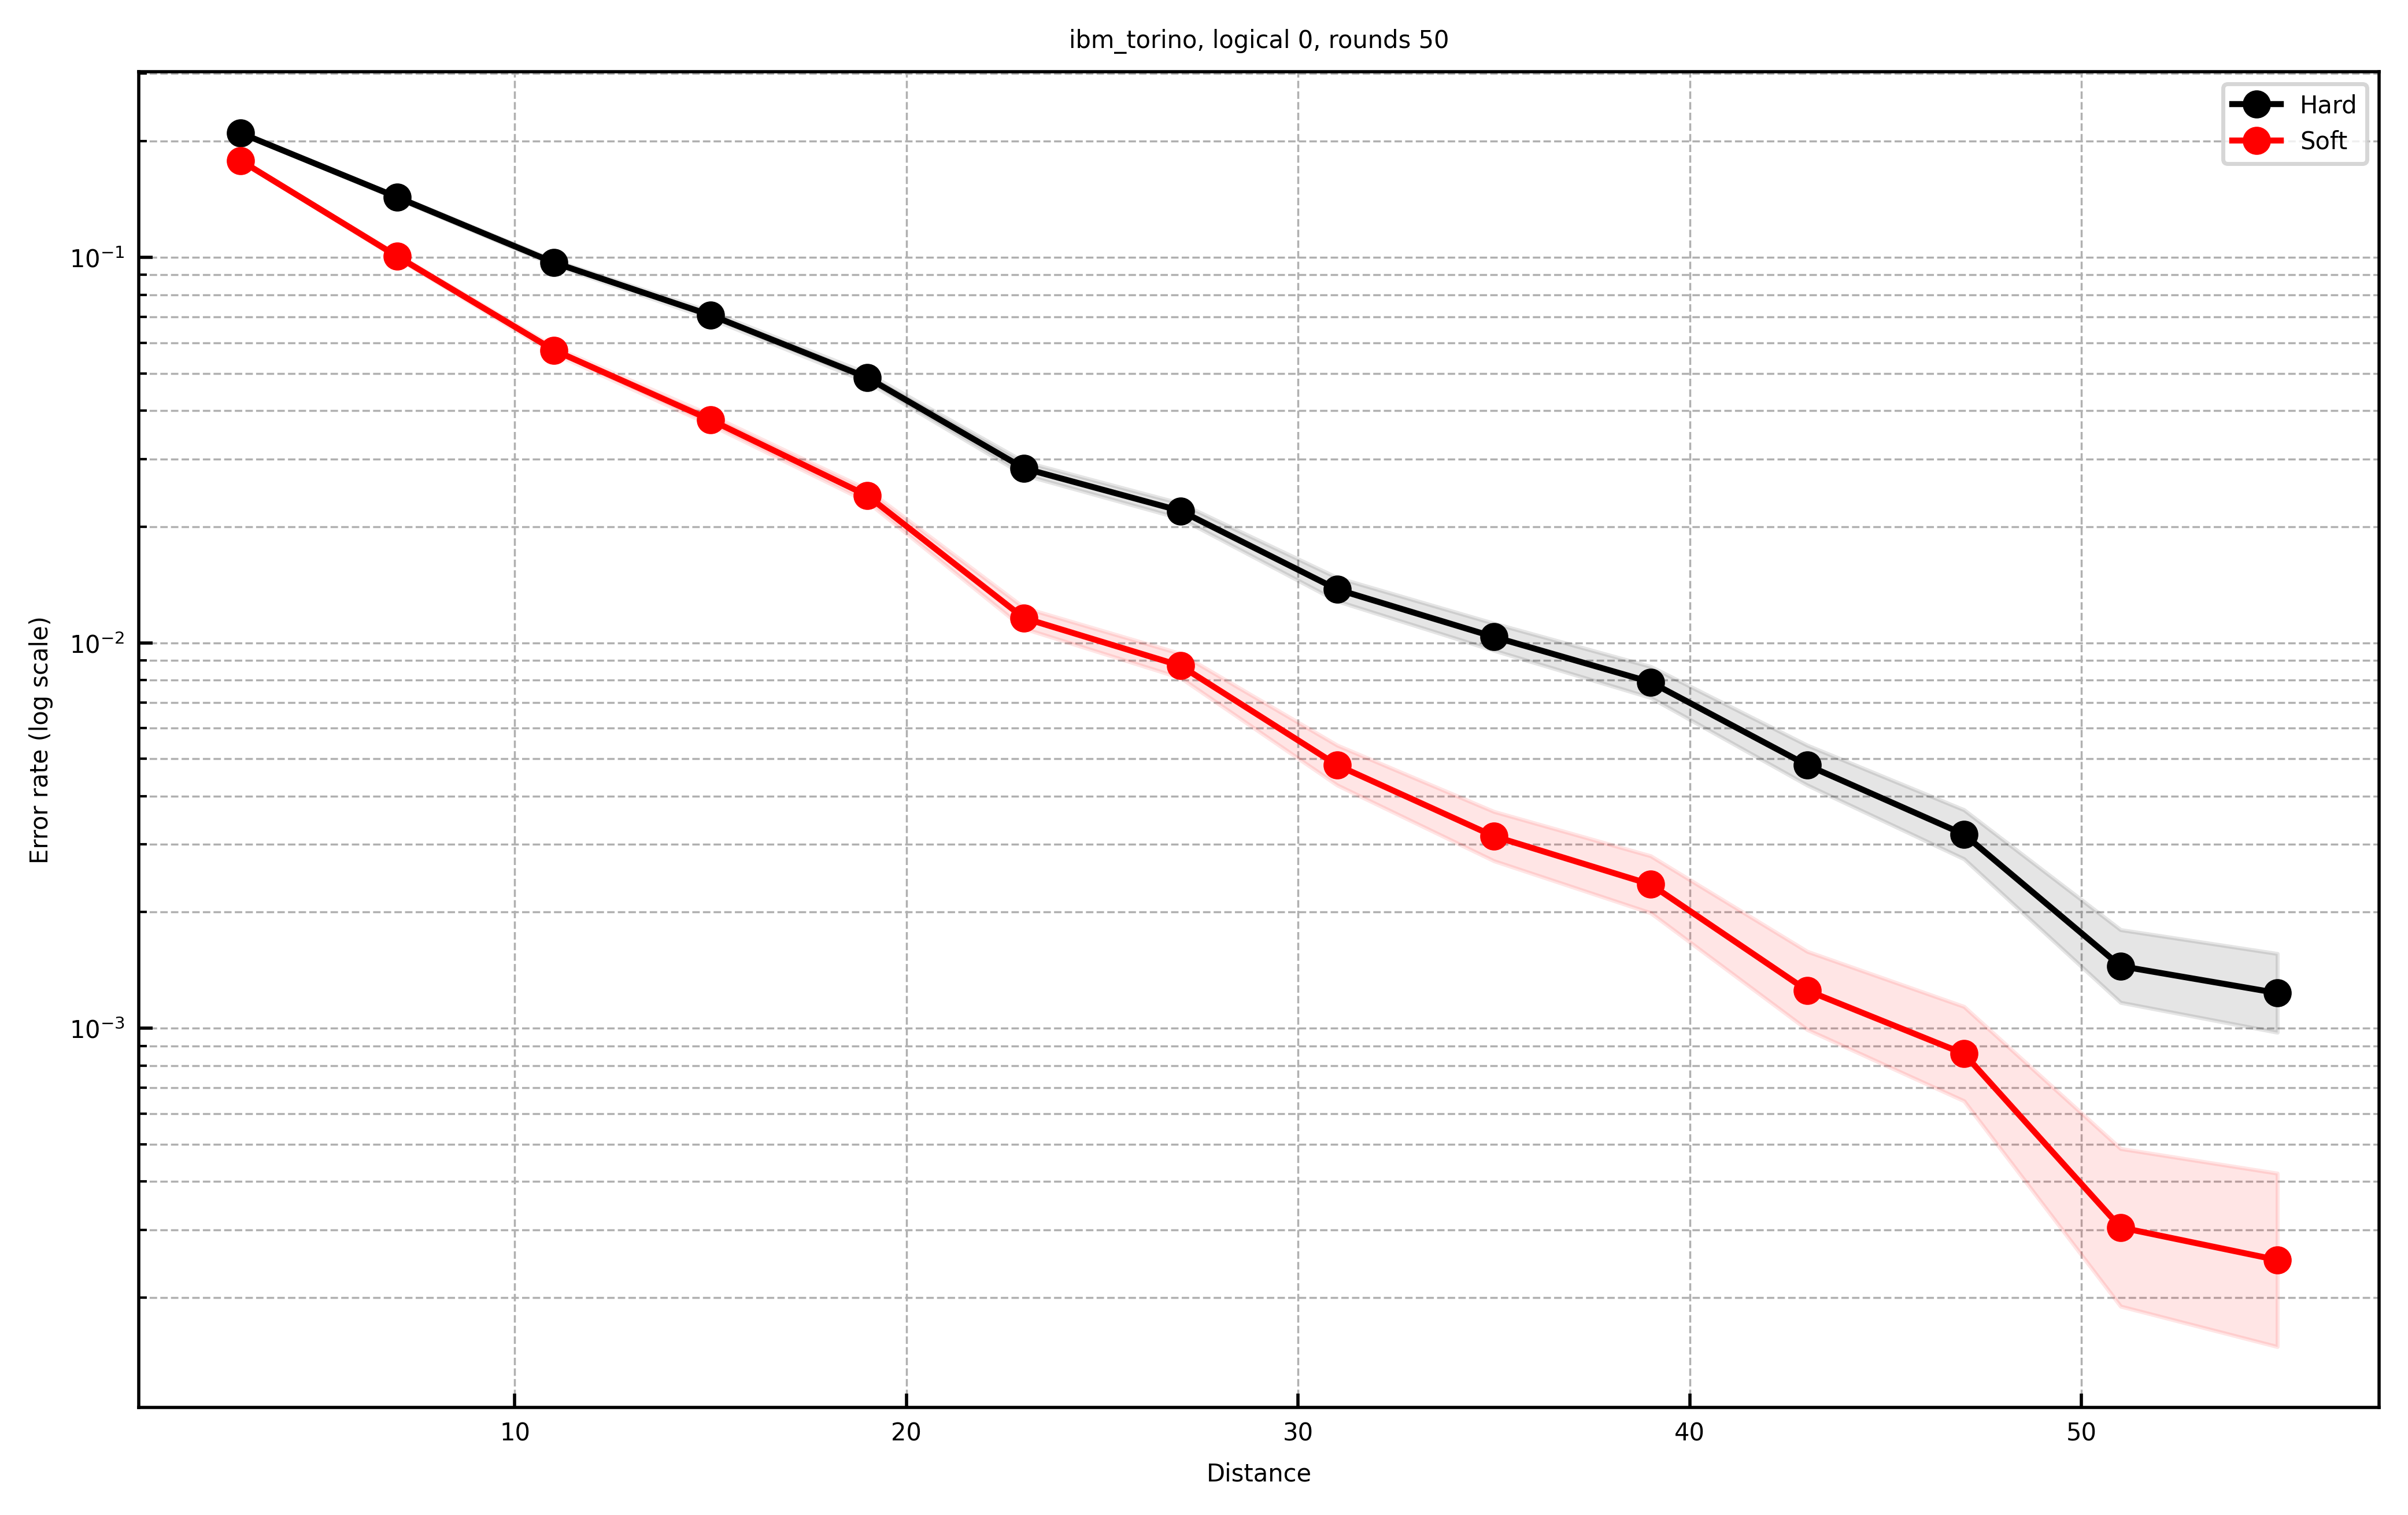

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

FIGURE_WIDTH_1COL = 3.404  # For PRX style, change for according to journal
FIGURE_WIDTH_2COL = 7.057  # For PRX style, change for according to journal
FIGURE_HEIGHT_1COL_GR = FIGURE_WIDTH_1COL*2/(1 + np.sqrt(5))*1.1
FIGURE_HEIGHT_2COL_GR = FIGURE_WIDTH_2COL*2/(1 + np.sqrt(5))*1.1

font_size = 6 # For PRX style, change for according to journal

plt.rcParams.update({
    'font.size'           : font_size,  
    'figure.titlesize'    : 'medium',
    'figure.dpi'          : 500,
    'figure.figsize'      : (FIGURE_WIDTH_1COL, FIGURE_HEIGHT_1COL_GR),
    'axes.titlesize'      : 'medium',
    'axes.axisbelow'      : True,
    'xtick.direction'     : 'in',
    'xtick.labelsize'     : 'small',
    'ytick.direction'     : 'in',
    'ytick.labelsize'     : 'small',
    'image.interpolation' : 'none',
    'legend.fontsize'     : font_size,
    'axes.labelsize'      : font_size,
    'axes.titlesize'      : font_size,
    'xtick.labelsize'     : font_size,
    'ytick.labelsize'     : font_size,
})


# Wilson score interval function
def wilson_score_interval(p, n, z=1.96):  # Using z=1.96 for a 95% confidence interval
    denominator = 1 + z**2 / n
    term = z * np.sqrt(p * (1 - p) / n + z**2 / (4 * n**2))
    lower = (p + z**2 / (2 * n) - term) / denominator
    upper = (p + z**2 / (2 * n) + term) / denominator
    return max(lower, 0), min(upper, 1)

err_rates_hard = []
err_rates_soft = []
hard_lowers = []
hard_uppers = []
soft_lowers = []
soft_uppers = []

for d in d_new_dict.keys():
    # For 'hard' decoding
    # p_hard = mean_err_rate_dict[d]["hard"]/mean_err_rate_dict[d]["shots"]
    # err_rates_hard.append(p_hard)
    # lower_hard, upper_hard = wilson_score_interval(p_hard, mean_err_rate_dict[d]["shots"])
    # hard_lowers.append(lower_hard)
    # hard_uppers.append(upper_hard)

    # For 'soft' decoding

    p_soft = mean_err_rate_dict[d]["kde"]/mean_err_rate_dict[d]["shots"]
    err_rates_soft.append(p_soft)
    lower_soft, upper_soft = wilson_score_interval(p_soft, mean_err_rate_dict[d]["shots"])
    soft_lowers.append(lower_soft)
    soft_uppers.append(upper_soft)

plt.figure(figsize=(10, 6))  # Adjust figure size as needed

# Plotting error rates for 'hard' and 'soft', including confidence intervals
plt.plot(distances, err_rates_hard, label="Hard", marker='o', color='black')
plt.fill_between(distances, hard_lowers, hard_uppers, color='black', alpha=0.1)
plt.plot(distances, err_rates_soft, label="Soft", marker='o', color='red')
plt.fill_between(distances, soft_lowers, soft_uppers, color='red', alpha=0.1)

plt.yscale("log")
plt.ylabel('Error rate (log scale)')
plt.xlabel('Distance')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.title(f"{DEVICE}, logical {LOGICAL}, rounds {ROUNDS}")

plt.show()

In [ ]:
# zip the distances and the error rates together
data = list(zip(distances, err_rates_hard, err_rates_soft))
data

[(3, 0.2100424075209483, 0.17821632945023502),
 (7, 0.14314735336194565, 0.10054363376251789),
 (11, 0.09687052932761087, 0.05741535526943252),
 (15, 0.07078862660944206, 0.037848712446351934),
 (19, 0.04874821173104435, 0.024087982832618027),
 (23, 0.028350023843586074, 0.011587982832618025),
 (27, 0.021983786361468766, 0.008714830710538865),
 (31, 0.01375178826895565, 0.004810443490701002),
 (35, 0.010354077253218885, 0.0031473533619456365),
 (39, 0.00790414878397711, 0.0023605150214592273),
 (43, 0.004810443490701002, 0.001251788268955651),
 (47, 0.0031831187410586554, 0.0008583690987124463),
 (51, 0.0014484978540772531, 0.00030400572246065807),
 (55, 0.0012339055793991417, 0.00025035765379113016)]

In [ ]:
# print the rates between the two decodings
for d, hard, soft in data:
    print(f"distance {d}: ratio {hard/soft:.2f}")

distance 3: ratio 1.18
distance 7: ratio 1.43
distance 11: ratio 1.69
distance 15: ratio 1.88
distance 19: ratio 2.04
distance 23: ratio 2.48
distance 27: ratio 2.68
distance 31: ratio 3.16
distance 35: ratio 3.49
distance 39: ratio 3.38
distance 43: ratio 3.99
distance 47: ratio 4.97
distance 51: ratio 5.60
distance 55: ratio 5.83
